In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "legend.fontsize": 18,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


In [3]:
out_path = "/users/amtseng/tfmodisco/figures/fold_model_motif_reproducibility_summary"
os.makedirs(out_path, exist_ok=True)

repro_hdf5s_base = "/users/amtseng/tfmodisco/figures/fold_model_motif_reproducibility"

repro_hdf5_paths = []  # (TF name, task index, path)
for subdir in os.listdir(repro_hdf5s_base):
    if not os.path.isdir(os.path.join(repro_hdf5s_base, subdir)):
        continue
    h5_name = [item for item in os.listdir(os.path.join(repro_hdf5s_base, subdir)) if item.endswith(".h5")][0]
    tf_name = subdir.split("_")[0]
    task_index = int(subdir.split("_")[1][4:])
    repro_hdf5_paths.append(
        (tf_name, task_index, os.path.join(repro_hdf5s_base, subdir, h5_name))
    )

### Helper functions

In [4]:
def get_total_reproducibility(repro_hdf5_path):
    """
    Imports the mean and stderr reproducibility value from the given
    saved HDF5.
    """
    with h5py.File(repro_hdf5_path, "r") as f:
        return f["total_mean_sim"][()], f["total_stderr_sim"][()]

### Import and plot reproducibility values

In [5]:
cond_keys = ["%s task %d" % (trip[0], trip[1]) for trip in repro_hdf5_paths]

In [6]:
total_repros = [get_total_reproducibility(trip[2])[0] for trip in repro_hdf5_paths]

In [7]:


def make_cdf(ax, data, steps=1000, density=False, inverse=False, **kwargs):
    """
    Plots a CDF to the given axes. `steps` is the number of steps in the
    CDF. If `inverse` is True, plots an inverse CDF (AKA survivorship plot).
    `density` is whether or not to normalize to fractions.
    """
    hist, bin_edges = np.histogram(data, bins=steps)
    if inverse:
        cumsum = len(data) - np.cumsum(hist)
    else:
        cumsum = np.cumsum(hist)
    if density:
        cumsum = cumsum / len(data)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    ax.step(bin_centers, cumsum, **kwargs)



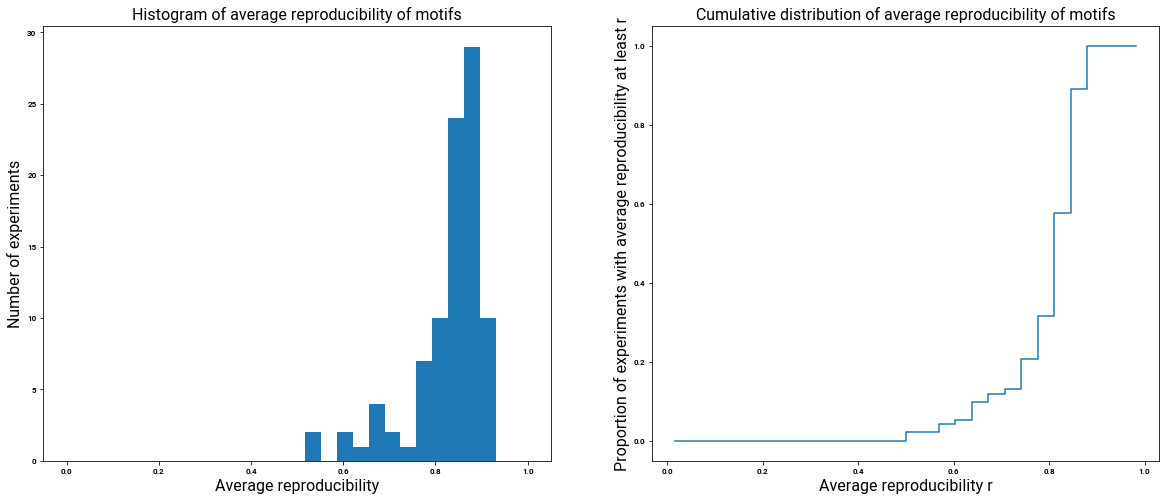

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

bins = np.linspace(0, 1, 30)

ax[0].hist(total_repros, bins=bins)

cdf_hist, cdf_bins = np.histogram(total_repros, bins=bins)
cdf_cumsum = np.cumsum(cdf_hist) / len(total_repros)
bin_centers = (cdf_bins[:-1] + cdf_bins[1:]) / 2.
ax[1].step(bin_centers, cdf_cumsum)

ax[0].set_title("Histogram of average reproducibility of motifs")
ax[1].set_title("Cumulative distribution of average reproducibility of motifs")

ax[0].set_xlabel("Average reproducibility")
ax[1].set_xlabel("Average reproducibility r")

ax[0].set_ylabel("Number of experiments")
ax[1].set_ylabel("Proportion of experiments with average reproducibility at least r")


plt.savefig(
    os.path.join(out_path, "fold_model_motif_reproducibility_summary.svg"),
    format="svg"
)
plt.show()